# Spatial analysis of variables on the hottest days
This looks at applying the theory from Byrne 2023 but to an aquaplanet.

Looks at how the hottest days compare to the theoretical upper bound temperature for a given the 500hPa temperature.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, mixing_ratio_from_partial_pressure, moist_static_energy, sphum_sat
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_time_slice, annual_mean
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import numpy_indexed
from scipy.stats import percentileofscore
from scipy import interpolate, integrate

2024-01-09 14:57:53,892 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [217]:
# Load dataset
exp_dir = 'aquaplanet/temp_tendency/'
# only keep variables required to compute relative humidity, MSE and miyawaki R1 value
var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'omega', 'ps', 'height', 'precipitation', 'swdn_sfc', 'lwdn_sfc',
            'flux_t', 'flux_lhe', 't_surf', 'klzbs', 'dt_tg_diffusion', 'dt_tg_convection', 'dt_tg_condensation', 
            'dt_qg_diffusion', 'dt_qg_convection', 'dt_qg_condensation', 'tdt_rad']
# exp_dir = 'aquaplanet/no_wishe/'
# var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'omega', 'ps', 'precipitation', 'swdn_sfc', 'lwdn_sfc',
#             'flux_t', 'flux_lhe', 't_surf']
tau_lw_ref = 1
exp_name = f"k={str(tau_lw_ref).replace('.','_')}"
ds = isca_tools.load_dataset(exp_dir + exp_name)
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']

## Get datasets
Get one dataset, `ds_lat`, for each latitude bin containing surface and free troposphere data for that latitude range.

In [303]:
# Get data set averaged over all summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2
pressure_ft = 500
# pressure_ft = 984

ds_use = ds.sel(time=slice(use_time_start, np.inf), drop=True)[var_keep]
ds_use = ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest', drop=True).load()
# omega_use = ds.sel(time=slice(use_time_start, np.inf), pfull=slice(pressure_ft, np.inf), drop=True).omega.load()
pressure_ft_actual = float(ds_use.pfull[0])        # actual free troposphere pressure in hPa
pressure_surface = float(ds_use.pfull[1])          # surface pressure in hPa

In [355]:
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20   # note that overall hottest day is at around 25 degrees
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90

### Figure 2 - Time series of annual hottest days
Below, I try to replicate Figure 2 in the paper. For each year in the simulation, I find the hottest day in each region (I actually get 2 values for each year - one in northern hemisphere and one in southern hemisphere, as the hemispheres are equivalent). For each of these days, I keep track of some variables in the 10 days preceeding and 10 days after the hottest day.

The plots then show these variables averaged over all years.

In [356]:
# Get all variables at surface and free troposphere on hottest day for each year considered
# Do separately for each hemisphere as should be indentical
n_years = int(len(ds_use.time)/360)         # multiply by 2 as each hemisphere is identical so get max from each
# Keep all variables in a (2*spatial_sz['lat']+1) x (2*spatial_sz['lon']+1) size grid centered on location of hottest day
spatial_sz = {'time':10, 'lat':10, 'lon':10}
n_year_days = 360       # number of days in a year

# define maximum day - either surface or lowest level temperature or where MSE diff between surface and free troposphere is largest
# max_def = 'surf_temp'
max_def = 'temp'
# max_def = 'mse_dev'

max_info = {'temp': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'height': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'ucomp': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'vcomp': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'omega': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'dt_tg_diffusion': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)), 
            'dt_tg_convection': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 
                                          2*spatial_sz['lon']+1, ds_use.pfull.size)), 
            'dt_tg_condensation': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 
                                          2*spatial_sz['lon']+1, ds_use.pfull.size)), 
            'dt_qg_diffusion': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'dt_qg_convection': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 
                                          2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'dt_qg_condensation': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 
                                            2*spatial_sz['lon']+1, ds_use.pfull.size)),
            'tdt_rad': np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds_use.pfull.size)), 
            'day': np.zeros((n_years, 2)),
            'lat': np.zeros((n_years, 2, 2*spatial_sz['lat']+1)),
            'lon': np.zeros((n_years, 2, 2*spatial_sz['lon']+1))
            }
surf_var = ['sphum', 'rh', 'precipitation', 'ps', 'swdn_sfc', 'lwdn_sfc', 'flux_t', 'flux_lhe', 't_surf', 'klzbs', 'w_atm']
for var in surf_var:
    max_info[var] = np.zeros((n_years, 2, 2*spatial_sz['time']+1, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1))

ind_use = {}
with (tqdm(total=n_years * 2, position=0, leave=True) as pbar):
    for k in range(2):
        if k == 0:
            # NH first
            ds_hem_all_years = ds_use.where((ds_use.lat<=lat_max) & (ds_use.lat>=lat_min), drop=True)
        else:
            ds_hem_all_years = ds_use.where((ds_use.lat<=-lat_min) & (ds_use.lat>=-lat_max), drop=True)
            
        # Choose how to find day to consider
        if max_def == 'surf_temp':
            ds_hem_all_years = ds_hem_all_years.t_surf.load()
        elif max_def == 'temp':
            ds_hem_all_years = ds_hem_all_years.temp[:, -1].load()
        elif max_def == 'mse_dev':
            try:
                ds_hem_all_years = ds_hem_all_years[['temp', 'sphum', 'height']].load()
                mse_surf_use = moist_static_energy(ds_hem_all_years.temp[:, -1], ds_hem_all_years.sphum[:, -1], ds_hem_all_years.height[:, -1])
                mse_ft_use = moist_static_energy(ds_hem_all_years.temp[:, 0], sphum_sat(ds_hem_all_years.temp[:, 0], pressure_ft_actual*100), 
                                             ds_hem_all_years.height[:, 0])
            except KeyError:
                # set to approximate values in no-WISHE case with no height
                ds_hem_all_years = ds_hem_all_years[['temp', 'sphum']].load()
                mse_surf_use = moist_static_energy(ds_hem_all_years.temp[:, -1], ds_hem_all_years.sphum[:, -1], 44)
                mse_ft_use = moist_static_energy(ds_hem_all_years.temp[:, 0], sphum_sat(ds_hem_all_years.temp[:, 0], pressure_ft_actual*100), 
                                                 5830)
            ds_hem_all_years = mse_surf_use - mse_ft_use
        else:
            raise ValueError(f'max_def = {max_def} is not valid.')
        
        for j in range(n_years):
            # Consider each year in turn
            ds_hem = ds_hem_all_years.sel(time=slice(ds_use.time[j*n_year_days], ds_use.time[(j+1)*n_year_days-1]))
            max_ind = ds_hem.argmax(dim=('time', 'lon', 'lat'))
            max_ind = {key: int(max_ind[key]) for key in max_ind}
            # convert max ind so refers to full dataset not hemisphere dataset for single year
            max_ind = {key: int(np.where(ds_use[key] == ds_hem[key][max_ind[key]])[0]) for key in max_ind}
            for i, key in enumerate(max_ind):
                ind_use[key] = np.arange(max_ind[key]-spatial_sz[key], max_ind[key]+spatial_sz[key]+1)
                if key == 'time':
                    # time is not circular coordinate so just clip times out of range to repeat first or last time.
                    ind_use[key] = np.clip(ind_use[key], 0, ds_use[key].size-1)
                # lon and lat are circular coordinates
                ind_use[key][ind_use[key]<0] += ds_use[key].size
                ind_use[key][ind_use[key]>=ds_use[key].size] -= ds_use[key].size
            ds_max = ds_use.isel(time=ind_use['time'], lat=ind_use['lat'], lon=ind_use['lon'])
            ds_max = ds_max.transpose(..., "pfull")        # put pressure dimension at the end
            max_info['day'][j, k] = ds_max.time[spatial_sz['time']]%n_year_days
            max_info['temp'][j, k] = ds_max.temp
            try:
                max_info['height'][j, k] = ds_max.height
            except AttributeError:
                max_info['height'][j, k, :, :, :] = [5830, 44]      # set to approximate values in no-WISHE case with no height
            max_info['ucomp'][j, k] = ds_max.ucomp
            max_info['vcomp'][j, k] = ds_max.vcomp
            max_info['omega'][j, k] = ds_max.omega
            max_info['dt_tg_diffusion'][j, k] = ds_max.dt_tg_diffusion
            max_info['dt_tg_convection'][j, k] = ds_max.dt_tg_convection
            max_info['dt_tg_condensation'][j, k] = ds_max.dt_tg_condensation
            max_info['dt_qg_diffusion'][j, k] = ds_max.dt_qg_diffusion
            max_info['dt_qg_convection'][j, k] = ds_max.dt_qg_convection
            max_info['dt_qg_condensation'][j, k] = ds_max.dt_qg_condensation
            max_info['tdt_rad'][j, k] = ds_max.tdt_rad
            # #set omega to average value between free trop and surface - use mass weighted integral
            # omega_max = omega_use.isel(time=ind_use['time'], lat=ind_use['lat'], lon=ind_use['lon'])
            # max_info['omega'][j, k] = np.expand_dims(integrate.simpson(omega_max/g,omega_max.pfull*100, axis=1)/
            #                                          integrate.simpson(omega_max/omega_max*g,omega_max.pfull*100, axis=1), -1)
            max_info['sphum'][j, k] = ds_max.sphum.sel(pfull=pressure_surface)
            max_info['rh'][j, k] = max_info['sphum'][j, k] / sphum_sat(ds_max.temp.sel(pfull=pressure_surface), pressure_surface*100)
            for var in surf_var:
                if var not in ['rh', 'sphum']:
                    max_info[var][j, k] = ds_max.get(var)
            max_info['lat'][j, k] = ds_max.lat
            max_info['lon'][j, k] = ds_max.lon
            pbar.update(1)

# Add empty axis to surface variables so same shape as surf+ft variables
max_info['ps'] = np.expand_dims(max_info['ps'], axis=-1)/100        # convert to hPa
max_info['mse'] = np.zeros_like(max_info['temp'])
max_info['mse'][:, :, :, :, :, 1] = moist_static_energy(max_info['temp'][:, :, :, :, :, 1], max_info['sphum'], 
                                                        max_info['height'][:, :, :, :, :, 1])
# Use saturated MSE for Free Troposphere
max_info['mse'][:, :, :, :, :, 0] = moist_static_energy(max_info['temp'][:, :, :, :, :, 0], 
                                                        sphum_sat(max_info['temp'][:, :, :, :, :, 0], pressure_ft_actual*100), 
                                                        max_info['height'][:, :, :, :, :, 0])
max_info['mse_diff'] = max_info['mse'][:, :, :, :, :, 1] - max_info['mse'][:, :, :, :, :, 0]
max_info['mse_diff'] = np.expand_dims(max_info['mse_diff'], axis=-1)
max_info['w_atm'] = np.sqrt(max_info['ucomp'][:, :, :, :, :, 1]**2 + max_info['vcomp'][:, :, :, :, :, 1]**2)
max_info['height'] = max_info['height']/1000                        # Convert to km
for var in surf_var:
    if len(max_info[var].shape) != 6:
        max_info[var] = np.expand_dims(max_info[var], axis=-1)
ft_ind = int(np.where(ds_max.pfull == pressure_ft_actual)[0])       # index of arrays corresponding to free troposphere

# Convert LZB into a pressure level
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds.pfull)), ds.pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    k = np.clip(k, 1, np.inf)       # so don't get error if k==0
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)
max_info['klzbs'] = lzb(max_info['klzbs'])

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


In [357]:
# Set to nan all values which cross from top of NH to bottom of SH and vice-versa
for j in range(n_years):
    out_range_nh = max_info['lat'][j, 0]<float(ds_use.lat[spatial_sz['lat']])
    out_range_sh = max_info['lat'][j, 1]>float(ds_use.lat[-spatial_sz['lat']])
    for key in max_info.keys():
        if key not in  ['lat', 'lon', 'day']:
            max_info[key][j, 0, :, out_range_nh] = np.nan
            max_info[key][j, 1, :, out_range_sh] = np.nan
    # Make so latitude is monotonically increasing - put out of bounds values as above 90 or below -90
    max_info['lat'][j, 0, out_range_nh] = np.nan
    max_info['lat'][j, 1, out_range_sh] = np.nan
    # max_info['lat'][j, 0, out_range_nh] += 90*2
    # max_info['lat'][j, 1, out_range_sh] -= 90*2

# Set longitude where crosses from 360 to 0 to just continue after 360
lon_out_range = np.where(np.diff(max_info['lon'], axis=2)<0)
for i in range(len(lon_out_range[0])):
    max_info['lon'][lon_out_range[0][i], lon_out_range[1][i], lon_out_range[2][i]+1:] += 360

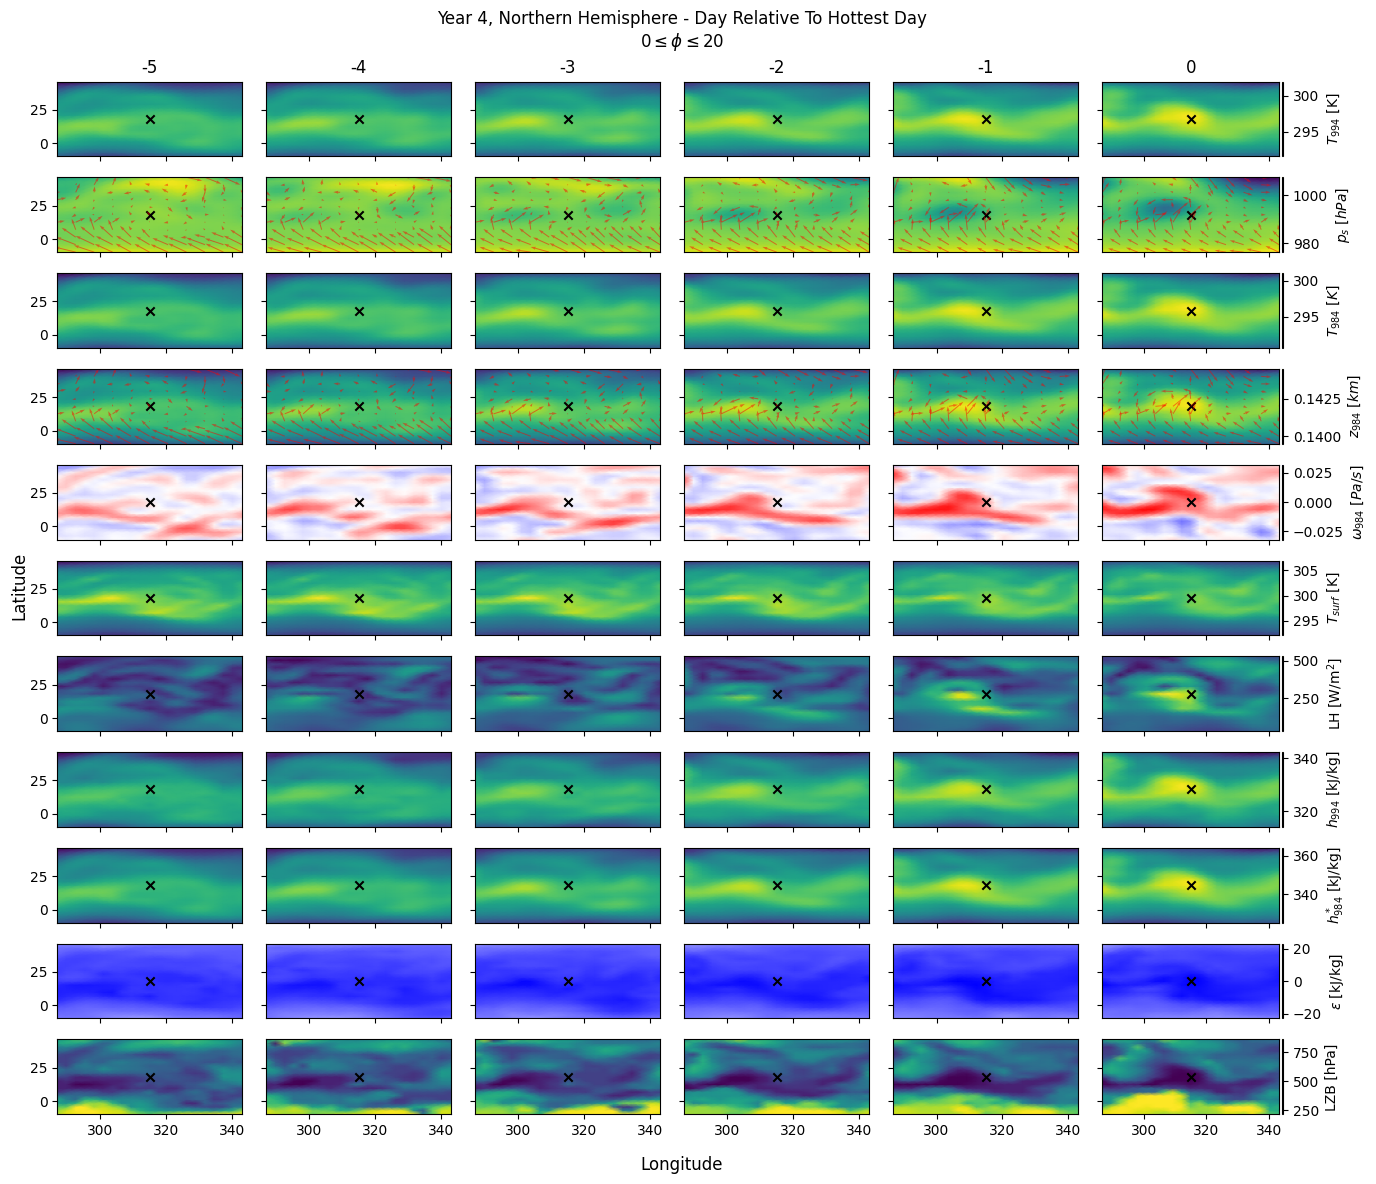

In [358]:
plot_ind = [4, 0]
plot_day = np.asarray([-5,-4,-3,-2,-1,0])
# plot_day = np.asarray([0, 1, 2, 3, 4, 5])
wind_spacing = 2    # larger means less dense arrows
cbar_param = {'aspect': 50, 'pad': 0.015, 'fraction': 0.03}
plot_info = {key: max_info[key][plot_ind[0], plot_ind[1], plot_day+spatial_sz['time']] for key in max_info if
             key not in ['lat', 'lon', 'day']}
plot_info['lat'] = max_info['lat'][plot_ind[0], plot_ind[1]]
plot_info['lon'] = max_info['lon'][plot_ind[0], plot_ind[1]]

max_coord = [plot_info['lat'][spatial_sz['lat']], plot_info['lon'][spatial_sz['lon']]]
for key in plot_info:
    if key not in ['lat', 'lon', 'day']:
        plot_info[key] = plot_info[key][:, ~np.isnan(plot_info['lat'])]
plot_info['lat'] = plot_info['lat'][~np.isnan(plot_info['lat'])]

var_name = ['temp', 'ps', 'temp', 'height', 'omega', 't_surf', 'flux_lhe', 'mse', 'mse', 'mse_diff', 'klzbs']
var_p_ind = [1, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
var_label = [f"$T_{'{'+str(int(pressure_surface))+'}'}$ [K]", '$p_s$ [$hPa$]', f"$T_{'{'+str(pressure_ft)+'}'}$ [$K$]",
             f"$z_{'{'+str(pressure_ft)+'}'}$ [$km$]", f"$\omega_{'{'+str(pressure_ft)+'}'}$ [$Pa/s$]", "$T_{surf}$ [K]", 'LH [W/m$^2$]', 
             f"$h_{'{'+str(int(pressure_surface))+'}'}$ [kJ/kg]", f"$h^*_{'{'+str(int(pressure_ft))+'}'}$ [kJ/kg]", '$\epsilon$ [kJ/kg]', 
             'LZB [hPa]']
fig, ax = plt.subplots(len(var_name), len(plot_day), figsize=(14,12), sharex=True, sharey=True)
for i in range(len(plot_day)):
    ax[0, i].set_title(plot_day[i])
    for j, var in enumerate(var_name):
        if var == 'omega' or var == 'mse_diff':
            clims = [-np.nanmax(np.abs(plot_info[var][:, :, :, var_p_ind[j]])),
                     np.nanmax(np.abs(plot_info[var][:, :, :, var_p_ind[j]]))]
            cmap = 'bwr_r' if var == 'omega' else 'bwr'
        else:
            clims = [np.nanmin(plot_info[var][:, :, :, var_p_ind[j]]),
                     np.nanmax(plot_info[var][:, :, :, var_p_ind[j]])]
            cmap = 'viridis'
        im = ax[j, i].pcolormesh(plot_info['lon'], plot_info['lat'], plot_info[var][i, :, :, var_p_ind[j]], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord[1], max_coord[0], marker='x', color='k')
        if var in ['ps', 'height']:
            pu, pv = plot_info['ucomp'][i, ::wind_spacing, ::wind_spacing, var_p_ind[j]], \
                plot_info['vcomp'][i, ::wind_spacing, ::wind_spacing, var_p_ind[j]]
            ax[j, i].quiver(plot_info['lon'][::wind_spacing], plot_info['lat'][::wind_spacing], pu, pv, alpha=0.5, color='r')
        if i == len(plot_day)-1:
            plt.colorbar(im, ax=ax[j, -1], label=var_label[j],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
             f' - Day Relative To Hottest Day\n${lat_min} \leq \\phi \leq {lat_max}$')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();

## Track MSE tendency
Look into contributions to surface MSE tendency to see what is dominating.

In [359]:
day_seconds = 24 * 60**2
# Ignore condensation because it is zero
tend_plot_info = {
    'mse': plot_info['mse'], 
    'dh_dt': np.diff(max_info['mse'][plot_ind[0], plot_ind[1]], axis=0)[plot_day+spatial_sz['time']], 
    # Convert others to units of kJ/kg/day
    'flux_lhe': plot_info['flux_lhe'],
    'dt_tg_diffusion': plot_info['dt_tg_diffusion'] * c_p / 1000 * day_seconds, 
    'dt_tg_convection': plot_info['dt_tg_convection'] * c_p / 1000 * day_seconds, 
    'tdt_rad': plot_info['tdt_rad'] * c_p / 1000 * day_seconds,
    'dt_qg_diffusion': plot_info['dt_qg_diffusion'] * L_v / 1000 * day_seconds,
    'dt_qg_convection': plot_info['dt_qg_convection'] * L_v / 1000 * day_seconds,
}
tend_plot_info['dt_tg_net'] = tend_plot_info['dt_tg_diffusion'] + tend_plot_info['dt_tg_convection'] + tend_plot_info['tdt_rad']  
tend_plot_info['dt_qg_net'] = tend_plot_info['dt_qg_diffusion'] + tend_plot_info['dt_qg_convection'] 
tend_plot_info['dt_hg_net'] = tend_plot_info['dt_qg_net'] + tend_plot_info['dt_tg_net']

# var_tend_p_ind = [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [360]:
def get_d_dx(var, lon, lat, lon_axis, lat_axis):
    # Returns d/dx
    lon = np.asarray(np.deg2rad(lon))
    lat = np.asarray(np.deg2rad(lat))
    cos_shape = np.ones_like(var.shape)
    cos_shape[lat_axis] = -1  # so multiply by cos of latitude along correct axis
    d_var_dx = (1 / radius_earth * np.cos(lat)).reshape(cos_shape) * np.gradient(var, lon, axis=lon_axis)
    return d_var_dx


def get_d_dy(var, lat, lat_axis):
    # Returns d/dy
    lat = np.asarray(np.deg2rad(lat))
    d_var_dy = (1 / radius_earth) * np.gradient(var, lat, axis=lat_axis)
    return d_var_dy


dvh_dy = get_d_dy(plot_info['mse'] * 1000 * plot_info['vcomp'], plot_info['lat'], lat_axis=1)
duh_dx = get_d_dx(plot_info['mse'] * 1000 * plot_info['ucomp'], plot_info['lon'], plot_info['lat'], lon_axis=2,
                  lat_axis=1)
# Omega only works if pressure_ft is next pressure level above surface
dwh_dp = np.diff(plot_info['mse'] * 1000 * plot_info['omega'], axis=-1) / (100 * (pressure_surface - pressure_ft_actual))
tend_plot_info['duh_dx'] = duh_dx / 1000 * day_seconds
tend_plot_info['dvh_dy'] = dvh_dy / 1000 * day_seconds
tend_plot_info['dwh_dp'] = dwh_dp / 1000 * day_seconds
tend_plot_info['_div'] = tend_plot_info['duh_dx'] + tend_plot_info['dvh_dy'] + tend_plot_info['dwh_dp']

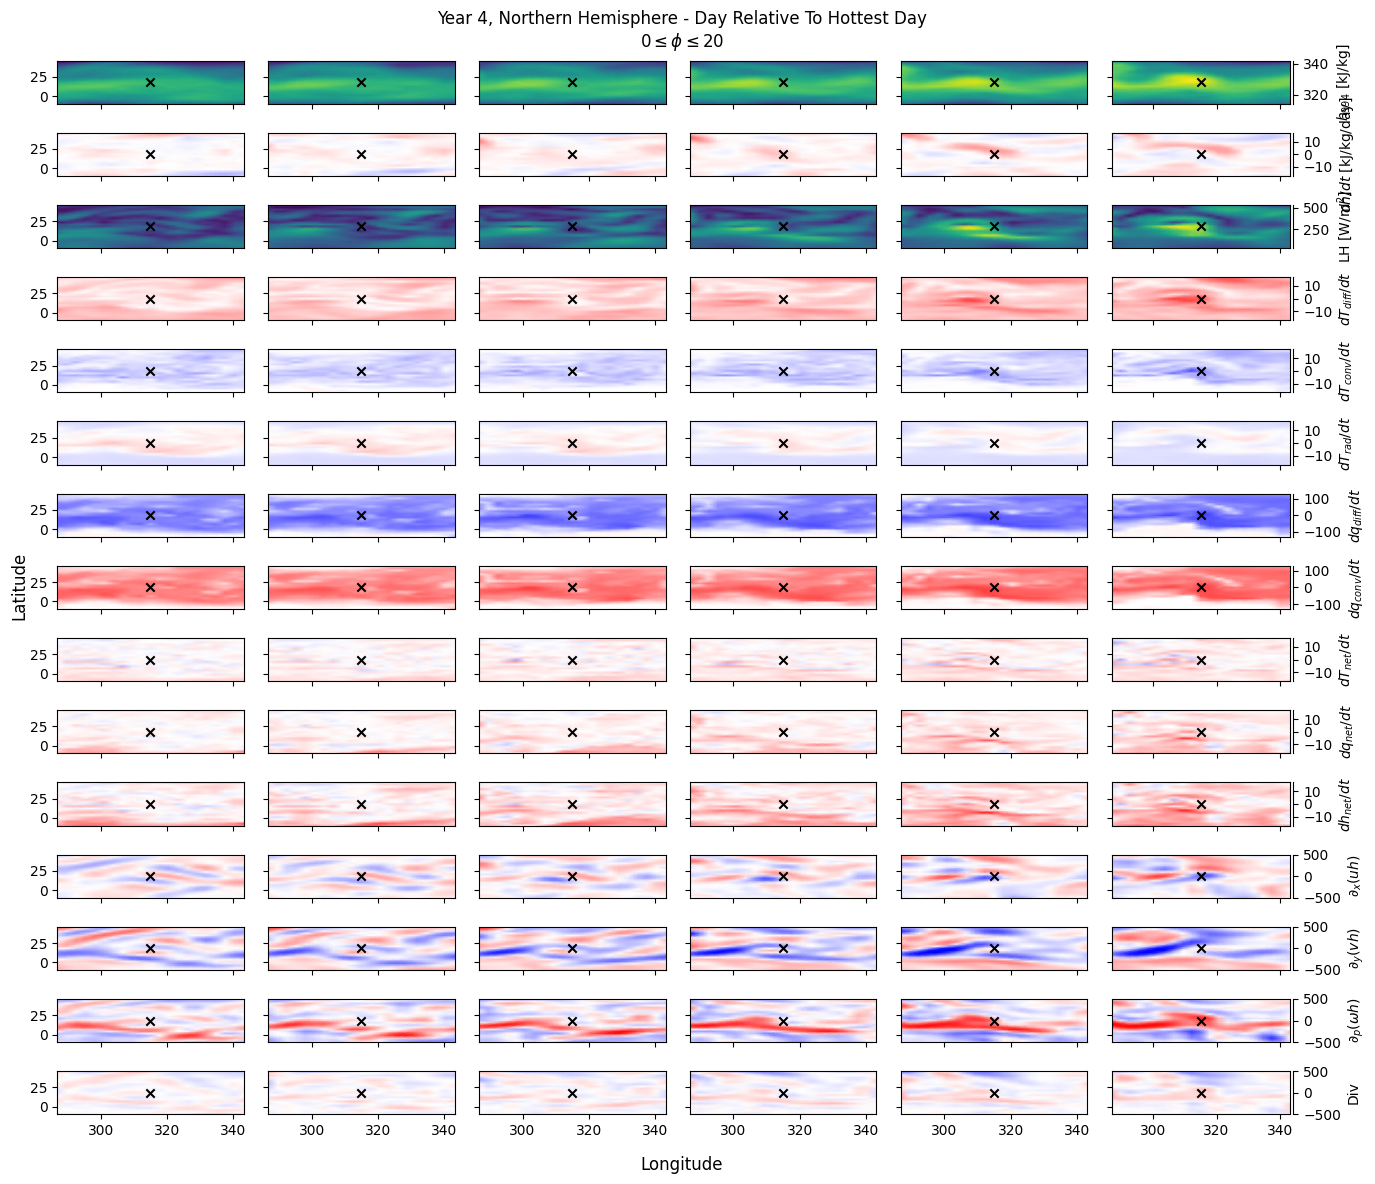

In [361]:
var_tend_label = [f"$h_{'{'+str(int(pressure_surface))+'}'}$ [kJ/kg]", "$dh/dt$ [kJ/kg/day]","LH [W/m$^2$]", 
                  "$dT_{diff}/dt$", "$dT_{conv}/dt$", "$dT_{rad}/dt$",
                  "$dq_{diff}/dt$", "$dq_{conv}/dt$", "$dT_{net}/dt$", "$dq_{net}/dt$", "$dh_{net}/dt$", 
                  "$\partial_x(uh)$", "$\partial_y(vh)$", "$\partial_p(\omega h)$", "Div"]
clims_t = 17
clims_q = 130
clims_div = 500

fig, ax = plt.subplots(len(tend_plot_info), len(plot_day), figsize=(14,12), sharex=True, sharey=True)
for i in range(len(plot_day)):
    for j, var in enumerate(tend_plot_info):
        # if var == 'omega' or var == 'mse_diff':
        #     clims = [-np.nanmax(np.abs(plot_info[var][:, :, :, var_p_ind[j]])),
        #              np.nanmax(np.abs(plot_info[var][:, :, :, var_p_ind[j]]))]
        #     cmap = 'bwr_r' if var == 'omega' else 'bwr'
        # else:
        var_tend_p_ind = 0 if (var == 'flux_lhe' or var=='dwh_dp') else 1
        if 'dt' not in var:
            if '_d' in var:
                clims = [-clims_div, clims_div]
                cmap = 'bwr'
            else:
                clims = [np.nanmin(tend_plot_info[var][:, :, :, var_tend_p_ind]),
                         np.nanmax(tend_plot_info[var][:, :, :, var_tend_p_ind])]
                cmap = 'viridis'
        else:
            if var == 'dt_qg_diffusion' or var ==  'dt_qg_convection':
                clims = [-clims_q, clims_q]
            else:
                clims = [-clims_t, clims_t]
            cmap = 'bwr'
        im = ax[j, i].pcolormesh(plot_info['lon'], plot_info['lat'], tend_plot_info[var][i, :, :, var_tend_p_ind], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord[1], max_coord[0], marker='x', color='k')
        if i == len(plot_day)-1:
            plt.colorbar(im, ax=ax[j, -1], label=var_tend_label[j],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])

fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
             f' - Day Relative To Hottest Day\n${lat_min} \leq \\phi \leq {lat_max}$')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();